# Fake News Detection

## Setup

In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import contractions
import string
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,f1_score
from scikitplot.metrics import plot_confusion_matrix

## Datasets

In [2]:
# import data
df_fake = pd.read_csv('data/DataSet_Misinfo_FAKE.csv')
df_true = pd.read_csv('data/DataSet_Misinfo_TRUE.csv')

# df_fake = pd.read_csv('data1/Fake.csv')
# df_true = pd.read_csv('data1/True.csv')

In [3]:
# check what data looks like
print('fake data')
df_fake.head()

fake data


,Unnamed: 0,text
0,0,Donald Trump just couldn't wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


In [4]:
print('true data')
df_true.head()

true data


,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [5]:
# add classes to data
df_fake['class'] = 0
df_true["class"] = 1

In [6]:
# check shape of the data
df_fake.shape, df_true.shape

((43642, 3), (34975, 3))

In [7]:
# check for null values
print('fake data')
for c in df_fake.columns:
    print(c, df_fake[c].isnull().sum())
    
print('\ntrue data')
for d in df_true.columns:
    print(d, df_true[d].isnull().sum())

fake data
Unnamed: 0 0
text 0
class 0

true data
Unnamed: 0 0
text 29
class 0


In [8]:
# show null values
null = df_true[df_true.isnull().any(axis=1)]
print(null)

      Unnamed: 0 text  class
2922        2922  NaN      1
3488        3488  NaN      1
3782        3782  NaN      1
4358        4358  NaN      1
4465        4465  NaN      1
5290        5290  NaN      1
5588        5588  NaN      1
5761        5761  NaN      1
5784        5784  NaN      1
6026        6026  NaN      1
6184        6184  NaN      1
6660        6660  NaN      1
6823        6823  NaN      1
7922        7922  NaN      1
8194        8194  NaN      1
8195        8195  NaN      1
8247        8247  NaN      1
8465        8465  NaN      1
8481        8481  NaN      1
8482        8482  NaN      1
8505        8505  NaN      1
8506        8506  NaN      1
8771        8771  NaN      1
8970        8970  NaN      1
9008        9008  NaN      1
9009        9009  NaN      1
9307        9307  NaN      1
9618        9618  NaN      1
9737        9737  NaN      1


In [9]:
# drop null values from df_true
new_df_true = df_true.dropna()

# recheck null values
print('true data')
for d in new_df_true.columns:
    print(d, new_df_true[d].isnull().sum())

true data
Unnamed: 0 0
text 0
class 0


In [10]:
# use first 30000 data of each dataset
frames = [df_fake.loc[:30000][:], new_df_true.loc[:30000][:]]

# get data for testing
test_frames = [df_fake.loc[30001:30050][:], new_df_true.loc[30001:30050][:]]

In [11]:
# merge both the datasets together
# df_merged = pd.concat([df_fake, new_df_true], axis = 0)

df_merged = pd.concat(frames, axis = 0)
df_merged

,Unnamed: 0,text,class
0,0,Donald Trump just couldn't wish all Americans ...,0
1,1,House Intelligence Committee Chairman Devin Nu...,0
2,2,"On Friday, it was revealed that former Milwauk...",0
3,3,"On Christmas day, Donald Trump announced that ...",0
4,4,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
29996,29996,PARIS — The ability of an Iranian directo...,1
29997,29997,"Friday at the White House, during a joint pres...",1
29998,29998,Good morning. Here’s what you need to know: •...,1
29999,29999,Yuko Takamatsu was somewhere in the sea off th...,1


In [12]:
# drop unwanted columns
df = df_merged.drop(['Unnamed: 0'], axis = 1)
df.head()

,text,class
0,Donald Trump just couldn't wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [13]:
# test dataset
df_test = pd.concat(test_frames, axis = 0)
df_test = df_test.sample(frac = 1)
df_test

,Unnamed: 0,text,class
30035,30035,Standing on the Third Street Bridge over the G...,1
30029,30029,Wednesday on CNN addressing media reports that...,1
30010,30010,President Donald Trump spent much of his Sunda...,1
30024,30024,A week of shocking violence in the United Stat...,1
30035,30750,There have been a wide array of reports sugges...,0
...,...,...,...
30047,30047,"VIENTIANE, Laos — President Obama has grown...",1
30019,30019,Pop star Katy Perry — one of Hillary Clinto...,1
30043,30758,"Ivanka is not her father, no more than you are...",0
30030,30745,UN special rapporteur on Palestine blasts Isra...,0


In [14]:
# drop unwanted columns
df_test = df_test.drop(['Unnamed: 0'], axis = 1)
df_test.head()

,text,class
30035,Standing on the Third Street Bridge over the G...,1
30029,Wednesday on CNN addressing media reports that...,1
30010,President Donald Trump spent much of his Sunda...,1
30024,A week of shocking violence in the United Stat...,1
30035,There have been a wide array of reports sugges...,0


## Text Preprocessing

In [15]:
# make all letters lowercase
df['lowercase'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,class,lowercase
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...


In [16]:
# URL removal
def removeURL(text):
    text = re.sub(r'http\S+', '', text)
    return text

In [17]:
df['no_url'] = df['lowercase'].apply(lambda x: removeURL(x))
df.head()

,text,class,lowercase,no_url
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...


In [18]:
# expand contractions
df['no_contractions'] = df['no_url'].apply(lambda x: [contractions.fix(w) for w in x.split()])

# convert back to string
df['no_contractions_str'] = [' '.join(map(str, r)) for r in df['no_contractions']]
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...


In [19]:
# tokenization
df['tokenized'] = df['no_contractions_str'].apply(word_tokenize)
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ..."


In [20]:
# remove punctuation
p = string.punctuation
df['no_punctuations'] = df['tokenized'].apply(lambda x: [w for w in x if w not in p])
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ..."


In [21]:
# remove stop words
stop_words = set(stopwords.words('english'))

# remove words with negation out of default stop words list
# neg = {'no', 'nor', 'not'}
# stop_words_no_neg = [n for n in stop_words if n not in neg]

df['no_stopwords'] = df['no_punctuations'].apply(lambda x: [w for w in x if w not in stop_words])
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations,no_stopwords
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a...","[donald, trump, could, wish, americans, happy,..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ...","[friday, revealed, former, milwaukee, sheriff,..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,...","[christmas, day, donald, trump, announced, wou..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ..."


In [22]:
# add pos tags
df['pos_tags'] = df['no_stopwords'].apply(nltk.tag.pos_tag)
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations,no_stopwords,pos_tags
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a...","[donald, trump, could, wish, americans, happy,...","[(donald, NNS), (trump, NN), (could, MD), (wis..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[(house, NN), (intelligence, NN), (committee, ..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ...","[friday, revealed, former, milwaukee, sheriff,...","[(friday, NN), (revealed, VBD), (former, JJ), ..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,...","[christmas, day, donald, trump, announced, wou...","[(christmas, NNS), (day, NN), (donald, VBZ), (..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ...","[(pope, NN), (francis, NN), (used, VBN), (annu..."


In [23]:
# convert to wordnet pos
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(w, get_wordnet_pos(t)) for (w, t) in x])
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations,no_stopwords,pos_tags,wordnet_pos
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a...","[donald, trump, could, wish, americans, happy,...","[(donald, NNS), (trump, NN), (could, MD), (wis...","[(donald, n), (trump, n), (could, n), (wish, v..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[(house, NN), (intelligence, NN), (committee, ...","[(house, n), (intelligence, n), (committee, n)..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ...","[friday, revealed, former, milwaukee, sheriff,...","[(friday, NN), (revealed, VBD), (former, JJ), ...","[(friday, n), (revealed, v), (former, a), (mil..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,...","[christmas, day, donald, trump, announced, wou...","[(christmas, NNS), (day, NN), (donald, VBZ), (...","[(christmas, n), (day, n), (donald, v), (trump..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ...","[(pope, NN), (francis, NN), (used, VBN), (annu...","[(pope, n), (francis, n), (used, v), (annual, ..."


In [24]:
# lemmatization
wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(w, t) for w, t in x])
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations,no_stopwords,pos_tags,wordnet_pos,lemmatized
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a...","[donald, trump, could, wish, americans, happy,...","[(donald, NNS), (trump, NN), (could, MD), (wis...","[(donald, n), (trump, n), (could, n), (wish, v...","[donald, trump, could, wish, american, happy, ..."
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[(house, NN), (intelligence, NN), (committee, ...","[(house, n), (intelligence, n), (committee, n)...","[house, intelligence, committee, chairman, dev..."
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ...","[friday, revealed, former, milwaukee, sheriff,...","[(friday, NN), (revealed, VBD), (former, JJ), ...","[(friday, n), (revealed, v), (former, a), (mil...","[friday, reveal, former, milwaukee, sheriff, d..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,...","[christmas, day, donald, trump, announced, wou...","[(christmas, NNS), (day, NN), (donald, VBZ), (...","[(christmas, n), (day, n), (donald, v), (trump...","[christmas, day, donald, trump, announce, woul..."
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ...","[(pope, NN), (francis, NN), (used, VBN), (annu...","[(pope, n), (francis, n), (used, v), (annual, ...","[pope, francis, use, annual, christmas, day, m..."


In [25]:
# convert back to string to be able to use tfidf vectorization later on
df['cleaned'] = [' '.join(map(str, r)) for r in df['lemmatized']]
df.head()

,text,class,lowercase,no_url,no_contractions,no_contractions_str,tokenized,no_punctuations,no_stopwords,pos_tags,wordnet_pos,lemmatized,cleaned
0,Donald Trump just couldn't wish all Americans ...,0,donald trump just couldn't wish all americans ...,donald trump just couldn't wish all americans ...,"[donald, trump, just, could not, wish, all, am...",donald trump just could not wish all americans...,"[donald, trump, just, could, not, wish, all, a...","[donald, trump, just, could, not, wish, all, a...","[donald, trump, could, wish, americans, happy,...","[(donald, NNS), (trump, NN), (could, MD), (wis...","[(donald, n), (trump, n), (could, n), (wish, v...","[donald, trump, could, wish, american, happy, ...",donald trump could wish american happy new yea...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev...","[(house, NN), (intelligence, NN), (committee, ...","[(house, n), (intelligence, n), (committee, n)...","[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,"on friday, it was revealed that former milwauk...","on friday, it was revealed that former milwauk...","[on, friday,, it, was, revealed, that, former,...","on friday, it was revealed that former milwauk...","[on, friday, ,, it, was, revealed, that, forme...","[on, friday, it, was, revealed, that, former, ...","[friday, revealed, former, milwaukee, sheriff,...","[(friday, NN), (revealed, VBD), (former, JJ), ...","[(friday, n), (revealed, v), (former, a), (mil...","[friday, reveal, former, milwaukee, sheriff, d...",friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",0,"on christmas day, donald trump announced that ...","on christmas day, donald trump announced that ...","[on, christmas, day,, donald, trump, announced...","on christmas day, donald trump announced that ...","[on, christmas, day, ,, donald, trump, announc...","[on, christmas, day, donald, trump, announced,...","[christmas, day, donald, trump, announced, wou...","[(christmas, NNS), (day, NN), (donald, VBZ), (...","[(christmas, n), (day, n), (donald, v), (trump...","[christmas, day, donald, trump, announce, woul...",christmas day donald trump announce would back...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...,pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...",pope francis used his annual christmas day mes...,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ...","[(pope, NN), (francis, NN), (used, VBN), (annu...","[(pope, n), (francis, n), (used, v), (annual, ...","[pope, francis, use, annual, christmas, day, m...",pope francis use annual christmas day message ...


In [26]:
# get specific columns that we will use
df_cleaned = df.loc[:, ['cleaned', 'class']]
df_cleaned.head()

,cleaned,class
0,donald trump could wish american happy new yea...,0
1,house intelligence committee chairman devin nu...,0
2,friday reveal former milwaukee sheriff david c...,0
3,christmas day donald trump announce would back...,0
4,pope francis use annual christmas day message ...,0


## Splitting Data

In [27]:
# splitting data into training and test sets
x = df_cleaned['cleaned']
y = df_cleaned['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((47978,), (11995,), (47978,), (11995,))

## Feature Extraction

In [28]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
tfidf.fit(x_train)
x_train_tfidf = tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

## Classifiers

### Support Vector Machine

In [29]:
# support vector machine
# svm = LinearSVC()
# svm = SVC(probability=True)
# svm.fit(x_train_tfidf, y_train)
# y_test_pred_svm_tfidf = svm.predict(x_test_tfidf)

# svm_tfidf_s = svm.score(x_test_tfidf, y_test)
# svm_tfidf_p = precision_score(y_test, y_test_pred_svm_tfidf, average='weighted')
# svm_tfidf_r = recall_score(y_test, y_test_pred_svm_tfidf, average='weighted')
# svm_tfidf_f = f1_score(y_test, y_test_pred_svm_tfidf, average='weighted')

# print('accuracy score: ' + str('{:04.2f}'.format(svm_tfidf_s * 100)) + '%')
# print('precision score: ' + str('{:04.2f}'.format(svm_tfidf_p * 100)) + '%')
# print('recall score: ' + str('{:04.2f}'.format(svm_tfidf_r * 100)) + '%')
# print('f1 score: ' + str('{:04.2f}'.format(svm_tfidf_f * 100)) + '%\n')
# print(classification_report(y_test, y_test_pred_svm_tfidf))

# sns.heatmap(confusion_matrix(y_test, y_test_pred_svm_tfidf),annot=True,fmt='.4g', cmap='viridis',
#             xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

### Naive Bayes

accuracy score: 93.99%
precision score: 94.40%
recall score: 93.99%
f1 score: 93.97%

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      5909
           1       0.90      0.99      0.94      6086

    accuracy                           0.94     11995
   macro avg       0.94      0.94      0.94     11995
weighted avg       0.94      0.94      0.94     11995



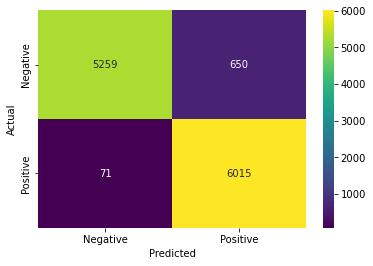

In [30]:
# multinomial naive bayes
mnb = MultinomialNB()
mnb.fit(x_train_tfidf, y_train)
y_test_pred_mnb_tfidf = mnb.predict(x_test_tfidf)

mnb_tfidf_s = mnb.score(x_test_tfidf, y_test)
mnb_tfidf_p = precision_score(y_test, y_test_pred_mnb_tfidf, average='weighted')
mnb_tfidf_r = recall_score(y_test, y_test_pred_mnb_tfidf, average='weighted')
mnb_tfidf_f = f1_score(y_test, y_test_pred_mnb_tfidf, average='weighted')

print('accuracy score: ' + str('{:04.2f}'.format(mnb_tfidf_s * 100)) + '%')
print('precision score: ' + str('{:04.2f}'.format(mnb_tfidf_p * 100)) + '%')
print('recall score: ' + str('{:04.2f}'.format(mnb_tfidf_r * 100)) + '%')
print('f1 score: ' + str('{:04.2f}'.format(mnb_tfidf_f * 100)) + '%\n')
print(classification_report(y_test, y_test_pred_mnb_tfidf))

sns.heatmap(confusion_matrix(y_test, y_test_pred_mnb_tfidf),annot=True,fmt='.4g', cmap='viridis',
            xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Logistic Regression

accuracy score: 96.78%
precision score: 96.78%
recall score: 96.78%
f1 score: 96.78%

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5909
           1       0.97      0.97      0.97      6086

    accuracy                           0.97     11995
   macro avg       0.97      0.97      0.97     11995
weighted avg       0.97      0.97      0.97     11995



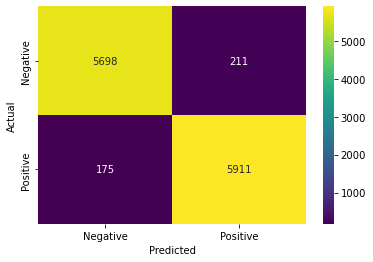

In [31]:
# logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_tfidf, y_train)
y_test_pred_lr_tfidf = lr.predict(x_test_tfidf)

lr_tfidf_s = lr.score(x_test_tfidf, y_test)
lr_tfidf_p = precision_score(y_test, y_test_pred_lr_tfidf, average='weighted')
lr_tfidf_r = recall_score(y_test, y_test_pred_lr_tfidf, average='weighted')
lr_tfidf_f = f1_score(y_test, y_test_pred_lr_tfidf, average='weighted')

print('accuracy score: ' + str('{:04.2f}'.format(lr_tfidf_s * 100)) + '%')
print('precision score: ' + str('{:04.2f}'.format(lr_tfidf_p * 100)) + '%')
print('recall score: ' + str('{:04.2f}'.format(lr_tfidf_r * 100)) + '%')
print('f1 score: ' + str('{:04.2f}'.format(lr_tfidf_f * 100)) + '%\n')
print(classification_report(y_test, y_test_pred_lr_tfidf))

sns.heatmap(confusion_matrix(y_test, y_test_pred_lr_tfidf),annot=True,fmt='.4g', cmap='viridis',
            xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### K-Nearest Neighbours

accuracy score: 86.45%
precision score: 86.55%
recall score: 86.45%
f1 score: 86.45%

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5909
           1       0.88      0.84      0.86      6086

    accuracy                           0.86     11995
   macro avg       0.87      0.86      0.86     11995
weighted avg       0.87      0.86      0.86     11995



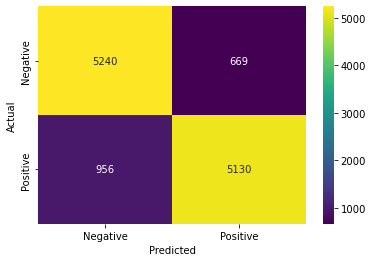

In [32]:
# k-nearest neighbours
knn = KNeighborsClassifier()
knn.fit(x_train_tfidf, y_train)
y_test_pred_knn_tfidf = knn.predict(x_test_tfidf)

knn_tfidf_s = knn.score(x_test_tfidf, y_test)
knn_tfidf_p = precision_score(y_test, y_test_pred_knn_tfidf, average='weighted')
knn_tfidf_r = recall_score(y_test, y_test_pred_knn_tfidf, average='weighted')
knn_tfidf_f = f1_score(y_test, y_test_pred_knn_tfidf, average='weighted')

print('accuracy score: ' + str('{:04.2f}'.format(knn_tfidf_s * 100)) + '%')
print('precision score: ' + str('{:04.2f}'.format(knn_tfidf_p * 100)) + '%')
print('recall score: ' + str('{:04.2f}'.format(knn_tfidf_r * 100)) + '%')
print('f1 score: ' + str('{:04.2f}'.format(knn_tfidf_f * 100)) + '%\n')
print(classification_report(y_test, y_test_pred_knn_tfidf))

sns.heatmap(confusion_matrix(y_test, y_test_pred_knn_tfidf),annot=True,fmt='.4g', cmap='viridis',
            xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Decision Tree

accuracy score: 94.32%
precision score: 94.33%
recall score: 94.32%
f1 score: 94.32%

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5909
           1       0.95      0.94      0.94      6086

    accuracy                           0.94     11995
   macro avg       0.94      0.94      0.94     11995
weighted avg       0.94      0.94      0.94     11995



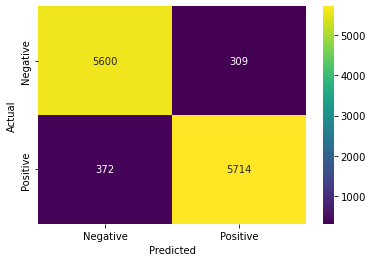

In [33]:
# decision tree
dt = DecisionTreeClassifier()
dt.fit(x_train_tfidf, y_train)
y_test_pred_dt_tfidf = dt.predict(x_test_tfidf)

dt_tfidf_s = dt.score(x_test_tfidf, y_test)
dt_tfidf_p = precision_score(y_test, y_test_pred_dt_tfidf, average='weighted')
dt_tfidf_r = recall_score(y_test, y_test_pred_dt_tfidf, average='weighted')
dt_tfidf_f = f1_score(y_test, y_test_pred_dt_tfidf, average='weighted')

print('accuracy score: ' + str('{:04.2f}'.format(dt_tfidf_s * 100)) + '%')
print('precision score: ' + str('{:04.2f}'.format(dt_tfidf_p * 100)) + '%')
print('recall score: ' + str('{:04.2f}'.format(dt_tfidf_r * 100)) + '%')
print('f1 score: ' + str('{:04.2f}'.format(dt_tfidf_f * 100)) + '%\n')
print(classification_report(y_test, y_test_pred_dt_tfidf))

sns.heatmap(confusion_matrix(y_test, y_test_pred_dt_tfidf),annot=True,fmt='.4g', cmap='viridis',
            xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
# place results within dataframes
# accuracy = {
#     "Classifier": ["Support Vector Machine", "Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
#                    "Decision Tree"],
#     "Accuracy Score": [svm_tfidf_s, mnb_tfidf_s, lr_tfidf_s, knn_tfidf_s, dt_tfidf_s]
# }

# accuracy_df = pd.DataFrame(accuracy)

# precision = {
#     "Classifier": ["Support Vector Machine", "Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
#                    "Decision Tree"],
#     "Precision Score": [svm_tfidf_p, mnb_tfidf_p, lr_tfidf_p, knn_tfidf_p, dt_tfidf_p]
# }

# precision_df = pd.DataFrame(precision)

# recall = {
#     "Classifier": ["Support Vector Machine", "Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
#                    "Decision Tree"],
#     "Recall Score": [svm_tfidf_r, mnb_tfidf_r, lr_tfidf_r, knn_tfidf_r, dt_tfidf_r]
# }

# recall_df = pd.DataFrame(recall)

# f1 = {
#     "Classifier": ["Support Vector Machine", "Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
#                    "Decision Tree"],
#     "F1 Score": [svm_tfidf_f, mnb_tfidf_f, lr_tfidf_f, knn_tfidf_f, dt_tfidf_f]
# }

# f1_df = pd.DataFrame(f1)

accuracy = {
    "Classifier": ["Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
                   "Decision Tree"],
    "Accuracy Score": [mnb_tfidf_s, lr_tfidf_s, knn_tfidf_s, dt_tfidf_s]
}

accuracy_df = pd.DataFrame(accuracy)

precision = {
    "Classifier": ["Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
                   "Decision Tree"],
    "Precision Score": [mnb_tfidf_p, lr_tfidf_p, knn_tfidf_p, dt_tfidf_p]
}

precision_df = pd.DataFrame(precision)

recall = {
    "Classifier": ["Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
                   "Decision Tree"],
    "Recall Score": [mnb_tfidf_r, lr_tfidf_r, knn_tfidf_r, dt_tfidf_r]
}

recall_df = pd.DataFrame(recall)

f1 = {
    "Classifier": ["Naive Bayes", "Logistic Regression", "K-Nearest Neighbours",
                   "Decision Tree"],
    "F1 Score": [mnb_tfidf_f, lr_tfidf_f, knn_tfidf_f, dt_tfidf_f]
}

f1_df = pd.DataFrame(f1)

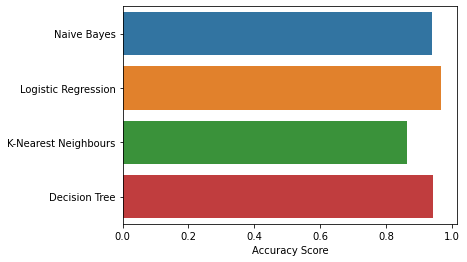

In [36]:
# plot bar graph of accuracy scores
sns.barplot(data=accuracy_df, y='Classifier', x='Accuracy Score')
plt.ylabel('')
plt.show()

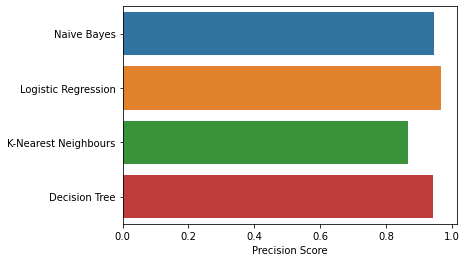

In [37]:
# plot bar graph of precision scores
sns.barplot(data=precision_df, y='Classifier', x='Precision Score')
plt.ylabel('')
plt.show()

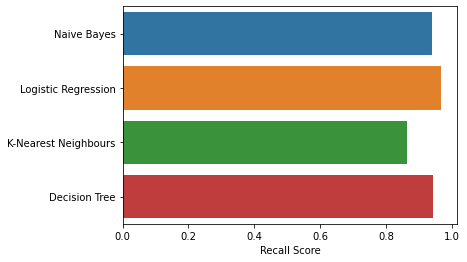

In [38]:
# plot bar graph of recall scores
sns.barplot(data=recall_df, y='Classifier', x='Recall Score')
plt.ylabel('')
plt.show()

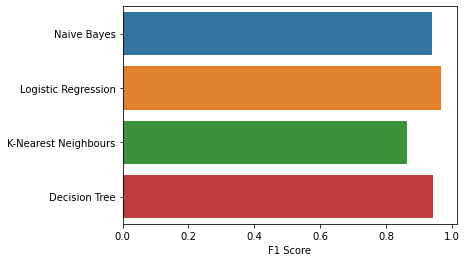

In [39]:
# plot bar graph of f1 scores
sns.barplot(data=f1_df, y='Classifier', x='F1 Score')
plt.ylabel('')
plt.show()

## Save Models and Vectorizer

In [40]:
# classification models
# pickle.dump(svm, open('model_svm.pkl', 'wb'))
pickle.dump(mnb, open('model_nb.pkl', 'wb'))
pickle.dump(lr, open('model_lr.pkl', 'wb'))
pickle.dump(knn, open('model_knn.pkl', 'wb'))
pickle.dump(dt, open('model_dt.pkl', 'wb'))

# vectorizer
pickle.dump(tfidf, open('tfidf_vec.pkl', 'wb'))

## Load Models and Vectorizer

In [41]:
# classification models
# svm_pkl = pickle.load(open('model_svm.pkl', 'rb'))
nb_pkl = pickle.load(open('model_nb.pkl', 'rb'))
lr_pkl = pickle.load(open('model_lr.pkl', 'rb'))
knn_pkl = pickle.load(open('model_knn.pkl', 'rb'))
dt_pkl = pickle.load(open('model_dt.pkl', 'rb'))

# vectorizer
tfidf_pkl = pickle.load(open('tfidf_vec.pkl', 'rb'))

## Testing

In [42]:
# function to return string based on class
def output_class(c):
    if c == 0:
        return 'Fake News'
    elif c == 1:
        return 'News Is True'

In [47]:
# function to test news from own input
def test_news(news):
    test_news = {'text': [news]}
    df_test = pd.DataFrame(test_news)

    # text preprocessing
    df_test['text'] = df_test['text'].apply(lambda x: x.lower())
    df_test['text'] = df_test['text'].apply(lambda x: removeURL(x))
    df_test['text'] = df_test['text'].apply(lambda x: [contractions.fix(w) for w in x.split()])
    df_test['text'] = [' '.join(map(str, r)) for r in df_test['text']]
    df_test['text'] = df_test['text'].apply(word_tokenize)
    df_test['text'] = df_test['text'].apply(lambda x: [w for w in x if w not in p])
    df_test['text'] = df_test['text'].apply(lambda x: [w for w in x if w not in stop_words])
    df_test['text'] = df_test['text'].apply(nltk.tag.pos_tag)
    df_test['text'] = df_test['text'].apply(lambda x: [(w, get_wordnet_pos(t)) for (w, t) in x])
    df_test['text'] = df_test['text'].apply(lambda x: [wnl.lemmatize(w, t) for w, t in x])
    df_test['text'] = [' '.join(map(str, r)) for r in df_test['text']]

    news_x_test = df_test['text']
    news_x_test_tfidf = tfidf_pkl.transform(news_x_test)

#     pred_svm = svm_pkl.predict(news_x_test_tfidf)
    pred_nb = nb_pkl.predict(news_x_test_tfidf)
    pred_lr = lr_pkl.predict(news_x_test_tfidf)
    pred_knn = knn_pkl.predict(news_x_test_tfidf)
    pred_dt = dt_pkl.predict(news_x_test_tfidf)

#     output = '\nSVM Prediction: {}\nNB Prediction: {}\nLR Prediction: {}\nKNN Prediction: {}\nDT Prediction: {}'
    output = '\nNB Prediction: {}\nLR Prediction: {}\nKNN Prediction: {}\nDT Prediction: {}'

#     return print(output.format(output_class(pred_svm[0]),
#                                output_class(pred_nb[0]),
#                                output_class(pred_lr[0]),
#                                output_class(pred_knn[0]),
#                                output_class(pred_dt[0])))

    return print(output.format(output_class(pred_nb[0]),
                               output_class(pred_lr[0]),
                               output_class(pred_knn[0]),
                               output_class(pred_dt[0])))

### Initial testing

In [48]:
# test
news = 'Donald Trump just couldn’t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn’t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!'
test_news(news)


NB Prediction: Fake News
LR Prediction: Fake News
KNN Prediction: Fake News
DT Prediction: News Is True


### Testing on unseen data

In [49]:
# text preprocessing
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: removeURL(x))
df_test['text'] = df_test['text'].apply(lambda x: [contractions.fix(w) for w in x.split()])
df_test['text'] = [' '.join(map(str, r)) for r in df_test['text']]
df_test['text'] = df_test['text'].apply(word_tokenize)
df_test['text'] = df_test['text'].apply(lambda x: [w for w in x if w not in p])
df_test['text'] = df_test['text'].apply(lambda x: [w for w in x if w not in stop_words])
df_test['text'] = df_test['text'].apply(nltk.tag.pos_tag)
df_test['text'] = df_test['text'].apply(lambda x: [(w, get_wordnet_pos(t)) for (w, t) in x])
df_test['text'] = df_test['text'].apply(lambda x: [wnl.lemmatize(w, t) for w, t in x])
df_test['text'] = [' '.join(map(str, r)) for r in df_test['text']]

df_test.head()

,text,class
30035,stand third street bridge gowanus canal brookl...,1
30029,wednesday cnn address medium report turn dossi...,1
30010,president donald trump spend much sunday send ...,1
30024,week shock violence united state take bloody t...,1
30035,wide array report suggest you.s government pre...,0


In [50]:
# testing test set
test_x = df_test['text']
test_y = df_test['class']

test_x_tfidf = tfidf.transform(test_x)

# pred_test_svm = svm_pkl.predict(test_x_tfidf)
pred_test_nb = nb_pkl.predict(test_x_tfidf)
pred_test_lr = lr_pkl.predict(test_x_tfidf)
pred_test_knn = knn_pkl.predict(test_x_tfidf)
pred_test_dt = dt_pkl.predict(test_x_tfidf)

In [51]:
# print('svm:')
# print(classification_report(test_y, pred_test_svm))
print('\nnb:')
print(classification_report(test_y, pred_test_nb))
print('\nlr:')
print(classification_report(test_y, pred_test_lr))
print('\nknn:')
print(classification_report(test_y, pred_test_knn))
print('\ndt:')
print(classification_report(test_y, pred_test_dt))


nb:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72        50
           1       0.70      0.94      0.80        50

    accuracy                           0.77       100
   macro avg       0.81      0.77      0.76       100
weighted avg       0.81      0.77      0.76       100


lr:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        50
           1       0.87      0.94      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100


knn:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100


dt